In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_results(solver, J, K, p, data_dir="../data"):
    """
    Read the CSV for given parameters and compute:
    1. Average runtime across all simulations.
    2. Average runtime for simulations where branch == 6.
    3. Proportion of simulations that are identifiable.
    4. Plot the distribution of the 'branch' variable.
    
    Handles mixed-type 'identifiable' values and prints summary to console.
    """
    filename = f"{data_dir}/solver{solver}_J{J}_K{K}_p{p}.csv"
    df = pd.read_csv(filename)
    
    # Convert mixed 'identifiable' to int 0/1
    df['identifiable'] = df['identifiable'].apply(
        lambda x: 1 if str(x).strip().lower() in ('1', 'true', 't', 'yes') else 0
    )

    # 1. Average runtime
    avg_runtime = df['runtime'].mean()
    
    # 2. Average runtime for branch == 6
    branch5 = df[df['branch'] == 5]
    avg_runtime_branch5 = branch5['runtime'].mean() if not branch5.empty else float('nan')
    branch6 = df[df['branch'] == 6]
    avg_runtime_branch6 = branch6['runtime'].mean() if not branch6.empty else float('nan')

    SAT = df[df['branch'].isin([5, 6])]
    avg_runtime_SAT = SAT['runtime'].mean() if not SAT.empty else float('nan')
    
    
    # 3. Proportion identifiable
    prop_identifiable = df['identifiable'].mean()
    
    # Print summary
    summary = pd.DataFrame({
        'Metric': [
            'Average runtime (all sims)',
            'avg_runtime_SAT',
            'avg_runtime_branch5',
            'avg_runtime_branch6',
            'Proportion identifiable'
        ],
        'Value': [
            avg_runtime,
            avg_runtime_SAT,
            avg_runtime_branch5,
            avg_runtime_branch6,
            prop_identifiable
        ]
    })
    print("\nSummary Statistics:")
    print(summary.to_string(index=False))
    
    # 4. Plot distribution of branch
    counts = df['branch'].value_counts().sort_index()
    plt.figure(figsize=(8, 4))
    counts.plot(kind='bar')
    plt.xlabel('Branch value')
    plt.ylabel('Count')
    plt.title(f'Distribution of branch for solver={solver}, J={J}, K={K}, p={p}')
    plt.tight_layout()
    plt.show()
    
    return avg_runtime, avg_runtime_SAT, avg_runtime_branch5, avg_runtime_branch6, prop_identifiable


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_simulation_results(solver, J, K, p_list):
    # Collect results
    results = {
        'p': [],
        'avg_runtime_all': [],
        'avg_runtime_SAT': [],
        'avg_runtime_branch5': [],
        'avg_runtime_branch6': [],
        'prop_identifiable': []
    }
    
    for p in p_list:
        avg_all, avg_sat, avg_b5, avg_b6, prop_id = analyze_results(solver, J, K, p)
        results['p'].append(p)
        results['avg_runtime_all'].append(avg_all)
        results['avg_runtime_SAT'].append(np.nan if np.isnan(avg_sat) else avg_sat)
        results['avg_runtime_branch5'].append(np.nan if np.isnan(avg_b5) else avg_b5)
        results['avg_runtime_branch6'].append(np.nan if np.isnan(avg_b6) else avg_b6)
        results['prop_identifiable'].append(prop_id)
    
    df = pd.DataFrame(results)

    # Figure 1: Identifiability with p
    plt.figure(figsize=(4, 3), dpi=300)
    plt.plot(df['p'], df['prop_identifiable'], marker='o')
    plt.xlabel('p')
    plt.ylabel('Proportion of identifiable')
    plt.title('Identifiability vs. p')
    plt.ylim(0, 1.2)
    plt.grid(True)
    plt.savefig(f'identifiability_with_p_K{K}.pdf', bbox_inches='tight')

    # Figure 2: Average Runtime vs p
    plt.figure(figsize=(4, 3), dpi=300)
    plt.plot(df['p'], df['avg_runtime_all'], marker='o', label='All simulations')
    # plt.plot(df['p'], df['avg_runtime_SAT'], marker='s', label='SAT-only sims')
    plt.xlabel('p')
    plt.ylabel('Average runtime (s)')
    plt.title('Average Runtime vs. p')
    # plt.legend()
    plt.grid(True)
    plt.savefig(f'runtime_vs_p_K{K}.pdf', bbox_inches='tight')

    # # Figure 3: SAT Runtime by Identifiability Outcome
    # plt.figure(figsize=(4, 3), dpi=300)
    # plt.plot(df['p'], df['avg_runtime_branch5'], marker='o', label='SAT non-identifiable')
    # plt.plot(df['p'], df['avg_runtime_branch6'], marker='s', label='SAT identifiable')
    # plt.xlabel('p')
    # plt.ylabel('SAT runtime (s)')
    # plt.title('SAT Runtime by Identifiability Outcome')
    # plt.legend()
    # plt.grid(True)
    # plt.savefig('sat_runtime_vs_p.pdf', bbox_inches='tight')

    # print("Plots saved: identifiability_with_p.pdf, runtime_vs_p.pdf, sat_runtime_by_outcome_vs_p.pdf")
    print("Plots saved: identifiability_with_p.pdf, runtime_vs_p.pdf")





Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.000879
           avg_runtime_SAT 0.004216
       avg_runtime_branch5      NaN
       avg_runtime_branch6 0.004216
   Proportion identifiable 1.000000


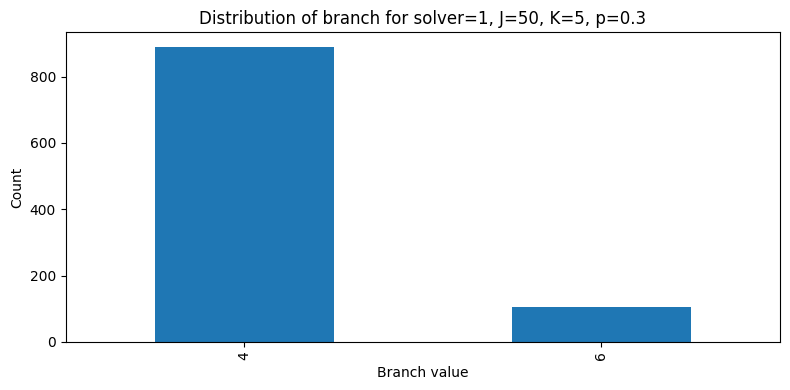


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.003097
           avg_runtime_SAT 0.004197
       avg_runtime_branch5      NaN
       avg_runtime_branch6 0.004197
   Proportion identifiable 1.000000


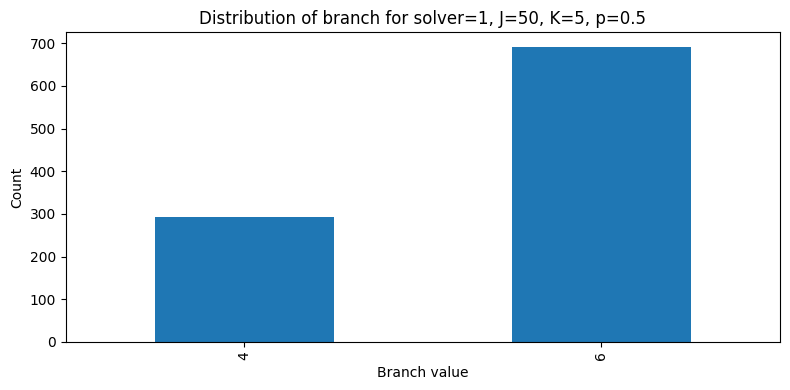


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.004313
           avg_runtime_SAT 0.004313
       avg_runtime_branch5 0.003948
       avg_runtime_branch6 0.004314
   Proportion identifiable 0.997957


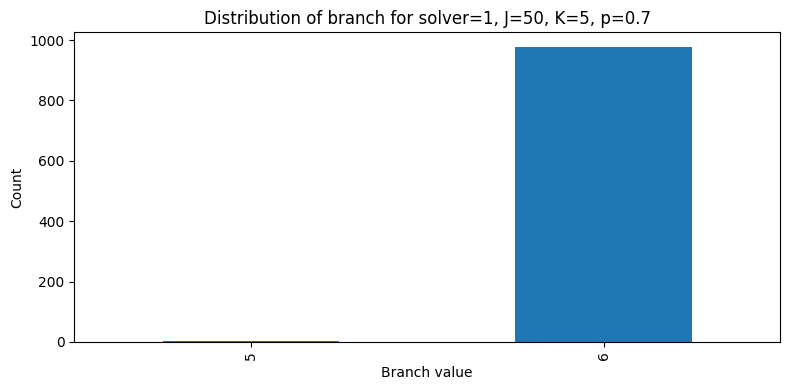

Plots saved: identifiability_with_p.pdf, runtime_vs_p.pdf


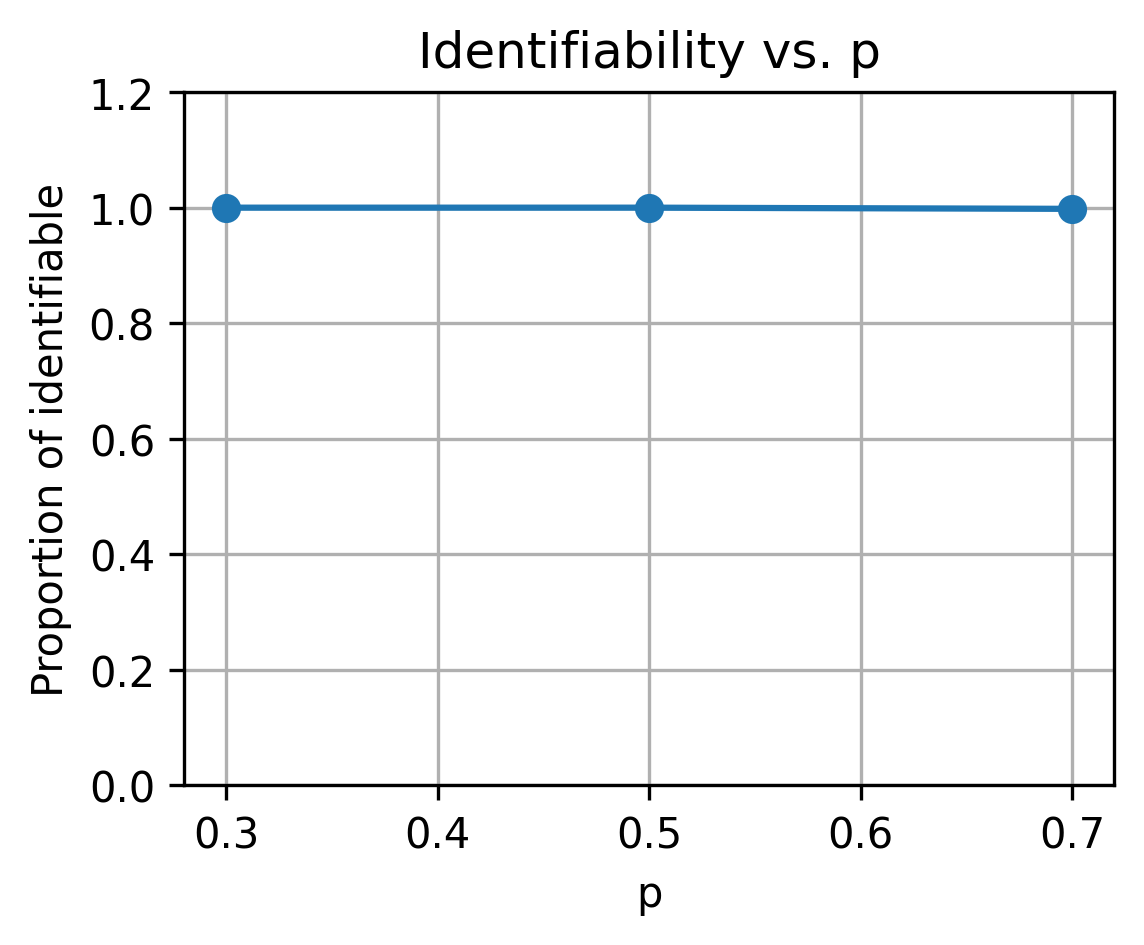

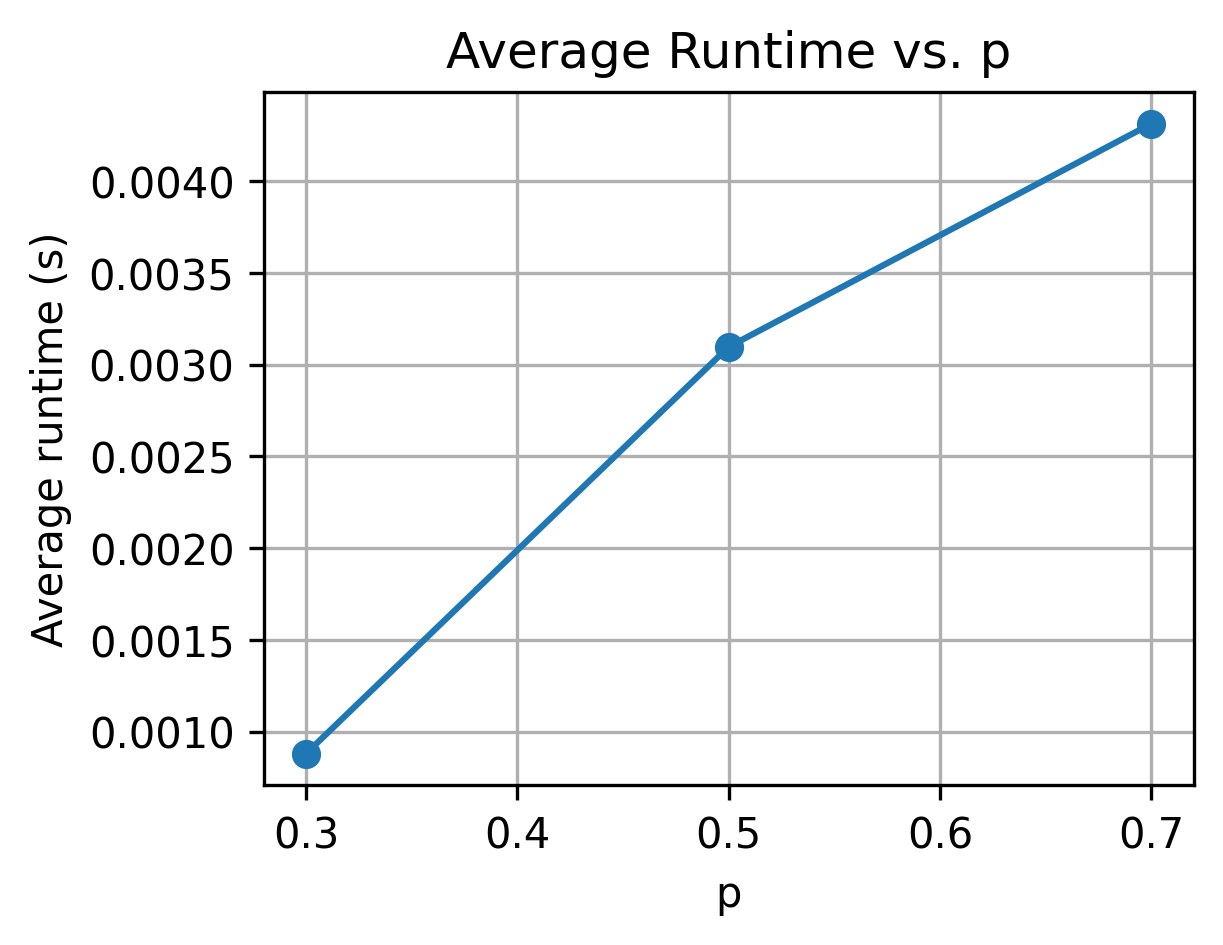

In [9]:
solver = 1
J, K = 50, 5
p_list = [0.3, 0.5, 0.7]
plot_simulation_results(solver, J, K, p_list)


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.384422
           avg_runtime_SAT 0.384808
       avg_runtime_branch5      NaN
       avg_runtime_branch6 0.384808
   Proportion identifiable 0.998985


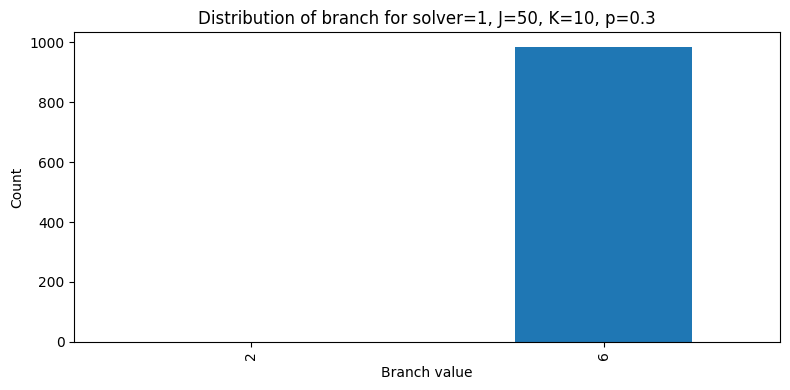


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.319443
           avg_runtime_SAT 0.319443
       avg_runtime_branch5      NaN
       avg_runtime_branch6 0.319443
   Proportion identifiable 1.000000


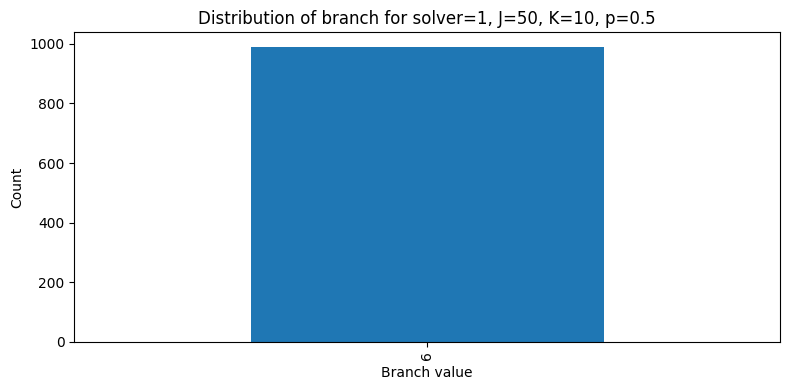


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 3.420471
           avg_runtime_SAT 3.448132
       avg_runtime_branch5 1.711162
       avg_runtime_branch6 3.572471
   Proportion identifiable 0.925703


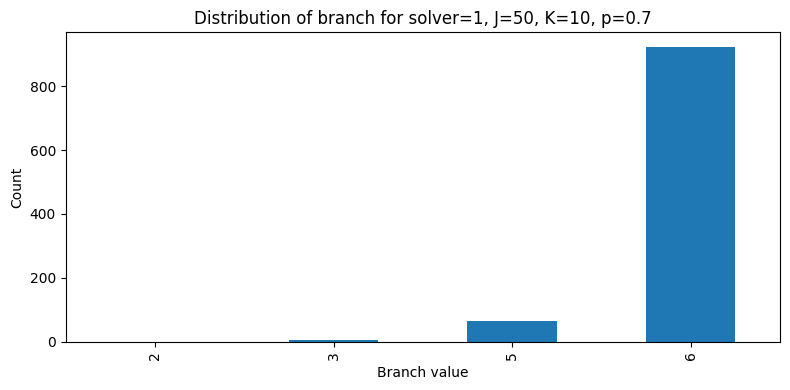

Plots saved: identifiability_with_p.pdf, runtime_vs_p.pdf


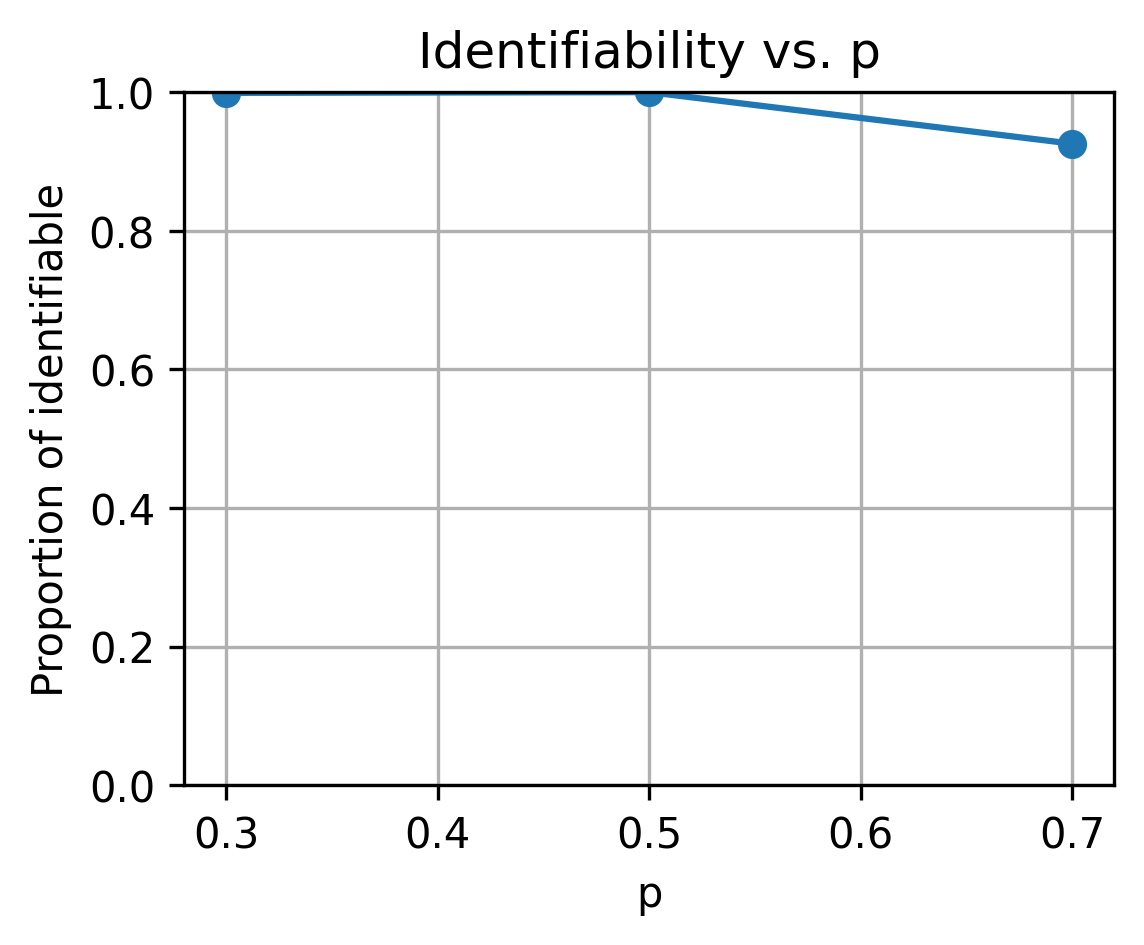

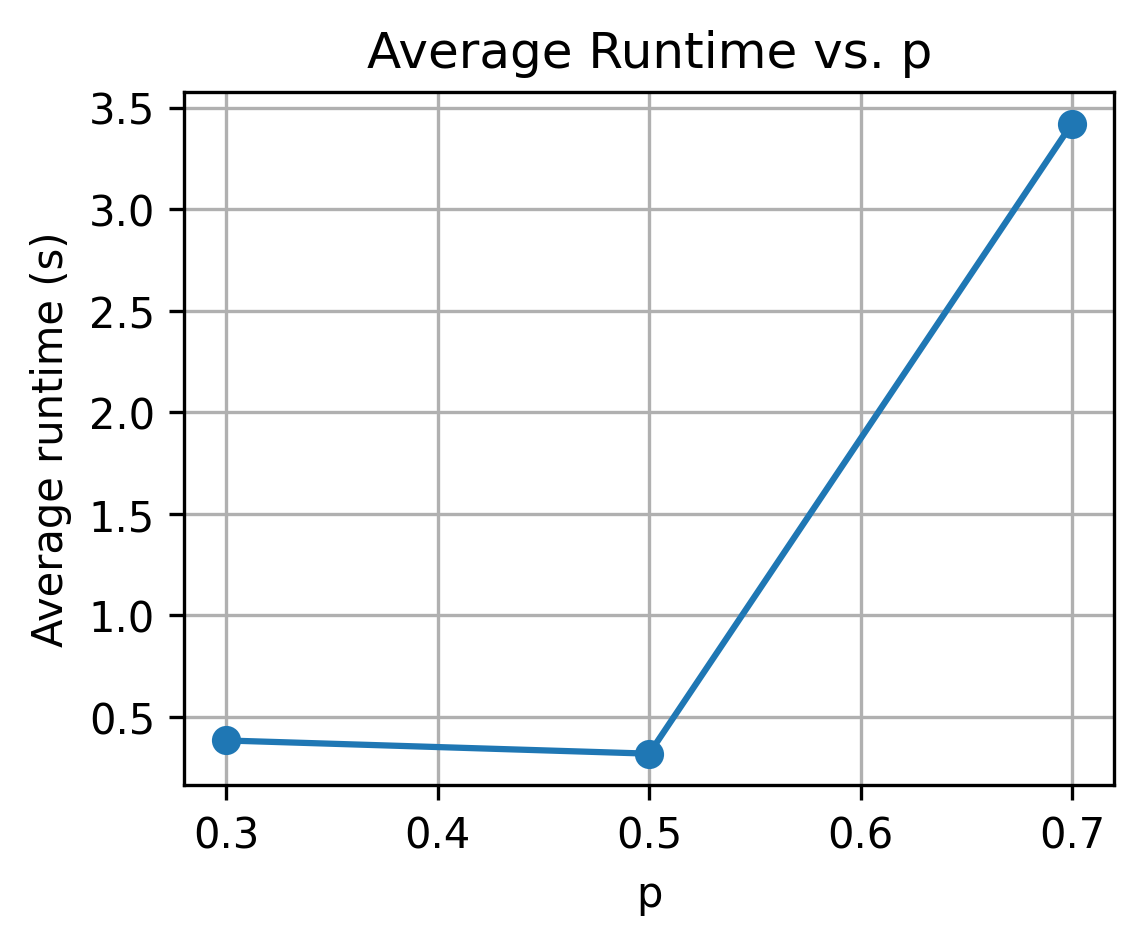

In [6]:
solver = 1
J, K = 50, 10
p_list = [0.3, 0.5, 0.7]
plot_simulation_results(solver, J, K, p_list)


Summary Statistics:
                    Metric     Value
Average runtime (all sims) 13.329163
           avg_runtime_SAT 13.342374
       avg_runtime_branch5       NaN
       avg_runtime_branch6 13.342374
   Proportion identifiable  0.999000


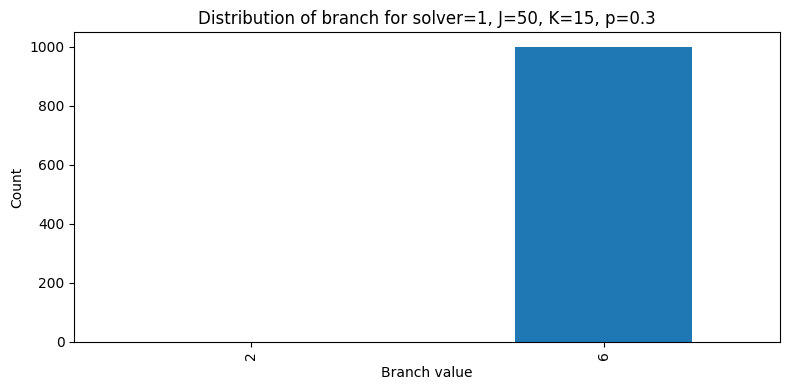


Summary Statistics:
                    Metric      Value
Average runtime (all sims) 397.561176
           avg_runtime_SAT 397.561176
       avg_runtime_branch5        NaN
       avg_runtime_branch6 397.561176
   Proportion identifiable   1.000000


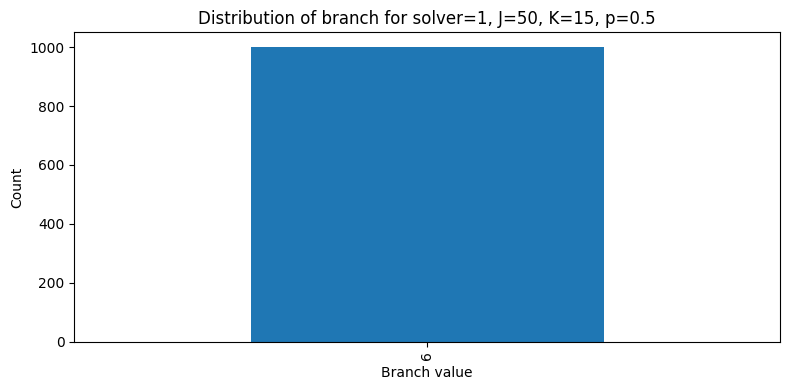


Summary Statistics:
                    Metric        Value
Average runtime (all sims) 11952.461122
           avg_runtime_SAT 12206.768525
       avg_runtime_branch5  5039.060370
       avg_runtime_branch6 89259.631184
   Proportion identifiable     0.083333


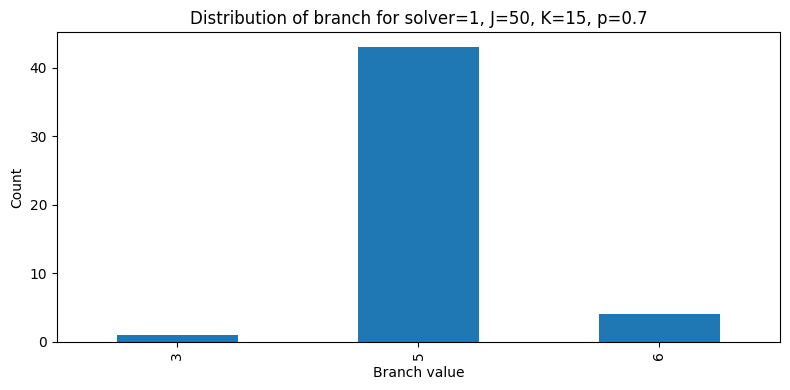

Plots saved: identifiability_with_p.pdf, runtime_vs_p.pdf


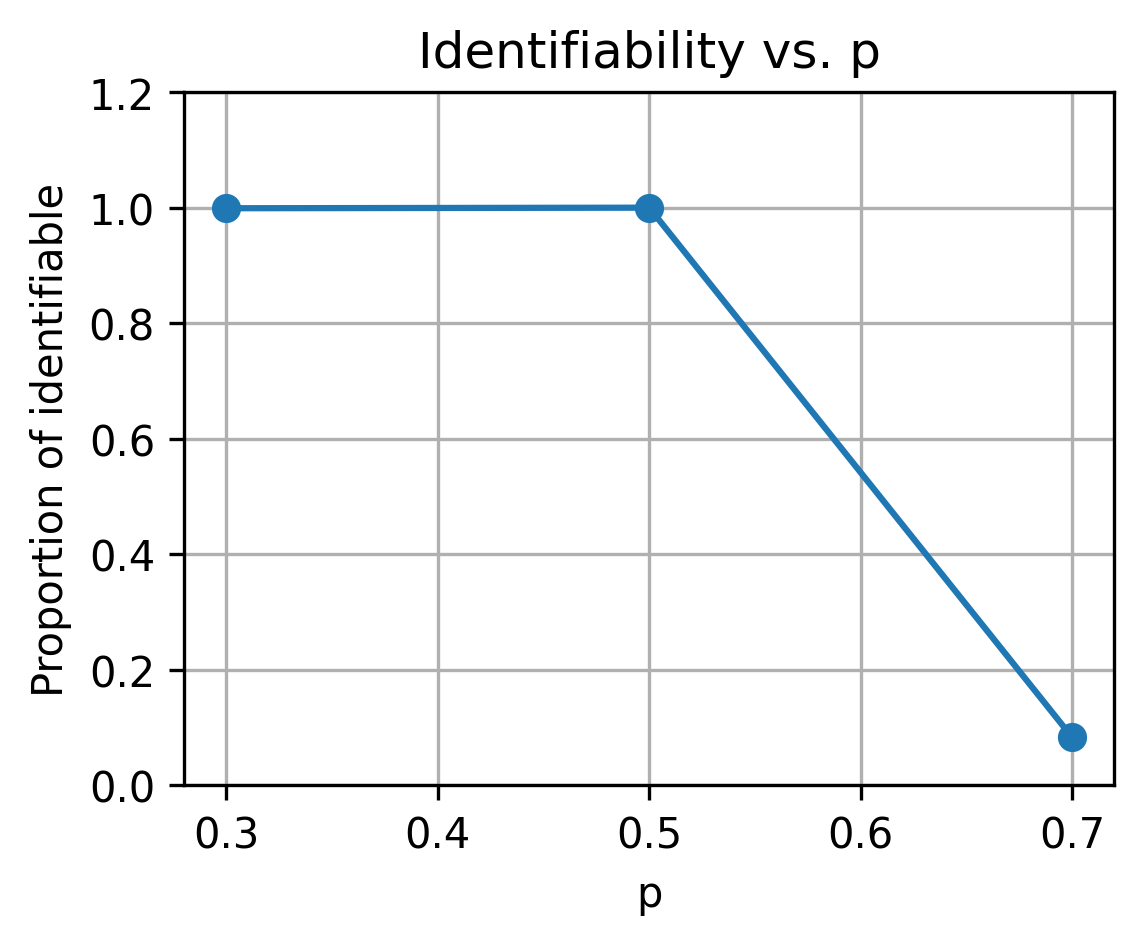

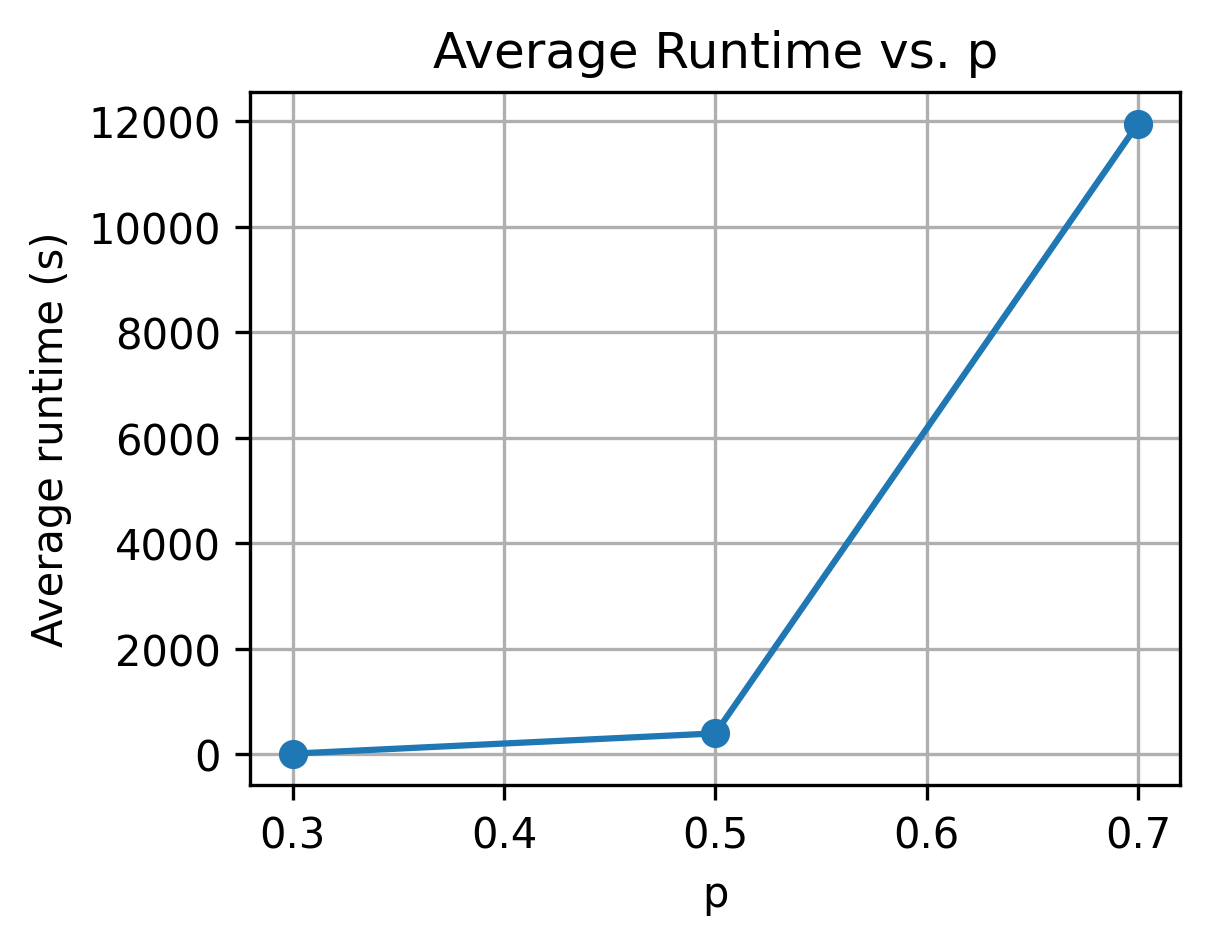

In [8]:
solver = 1
J, K = 50, 15
p_list = [0.3, 0.5, 0.7]
plot_simulation_results(solver, J, K, p_list)


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.520426
           avg_runtime_SAT 1.004108
       avg_runtime_branch5      NaN
       avg_runtime_branch6 1.004108
   Proportion identifiable 0.732053


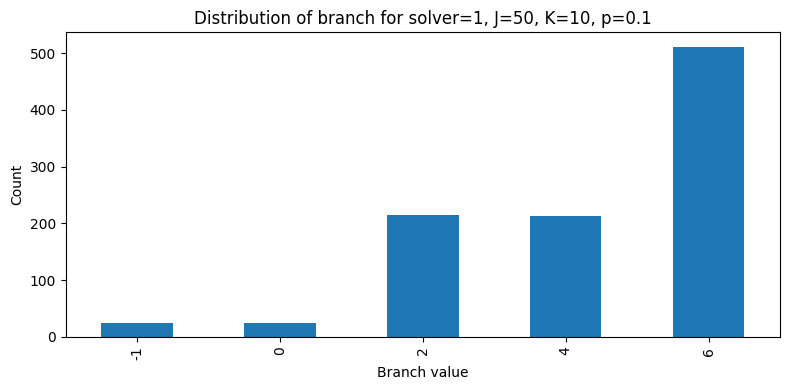


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 1.771229
           avg_runtime_SAT 1.853528
       avg_runtime_branch5      NaN
       avg_runtime_branch6 1.853528
   Proportion identifiable 0.994944


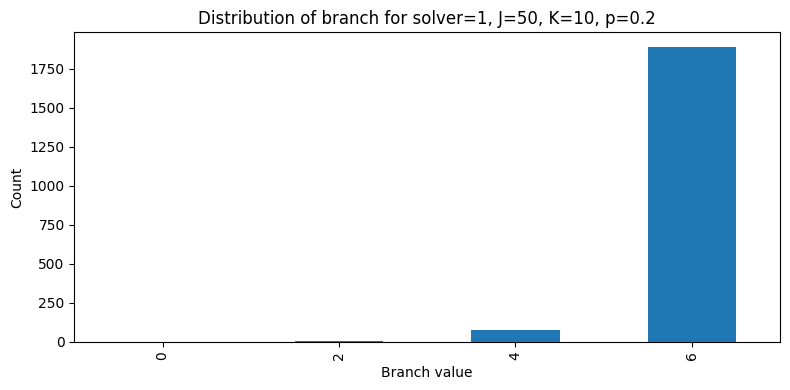


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 2.957839
           avg_runtime_SAT 2.960810
       avg_runtime_branch5      NaN
       avg_runtime_branch6 2.960810
   Proportion identifiable 0.998995


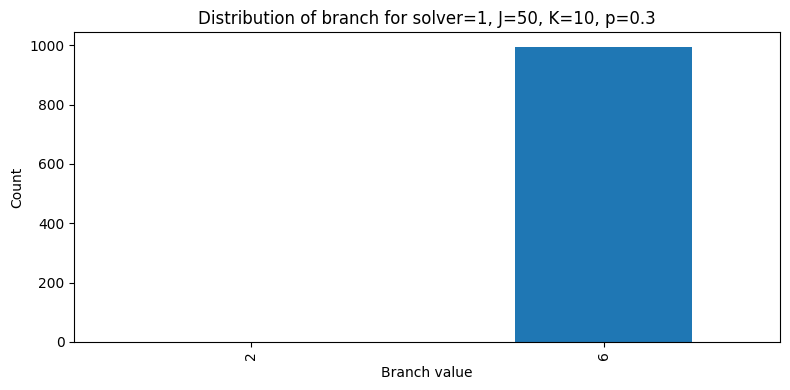


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 2.891905
           avg_runtime_SAT 2.891905
       avg_runtime_branch5      NaN
       avg_runtime_branch6 2.891905
   Proportion identifiable 1.000000


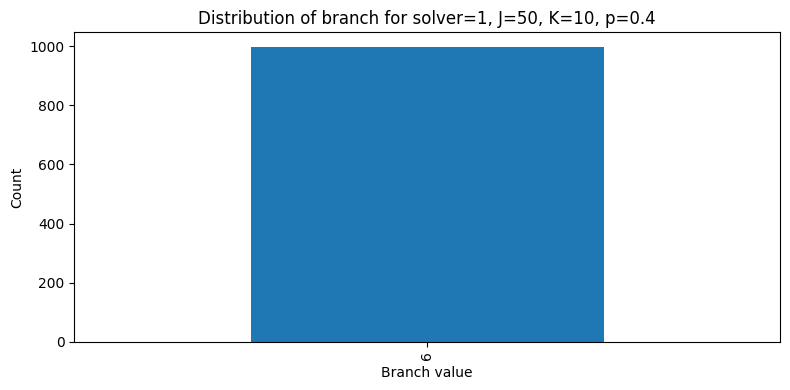


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 2.190613
           avg_runtime_SAT 2.190613
       avg_runtime_branch5      NaN
       avg_runtime_branch6 2.190613
   Proportion identifiable 1.000000


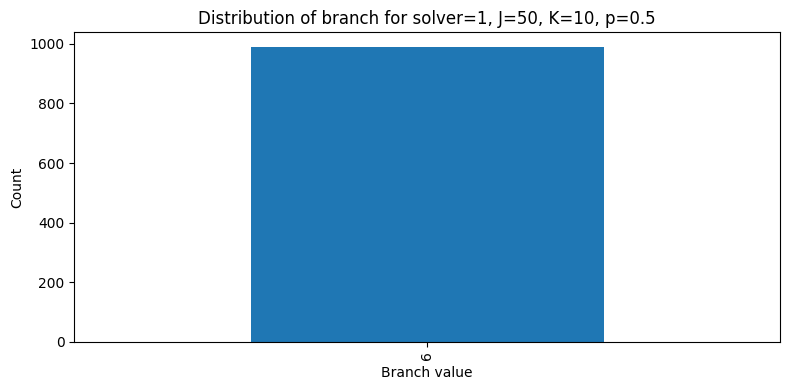


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 2.538714
           avg_runtime_SAT 2.538714
       avg_runtime_branch5 1.993177
       avg_runtime_branch6 2.539262
   Proportion identifiable 0.998998


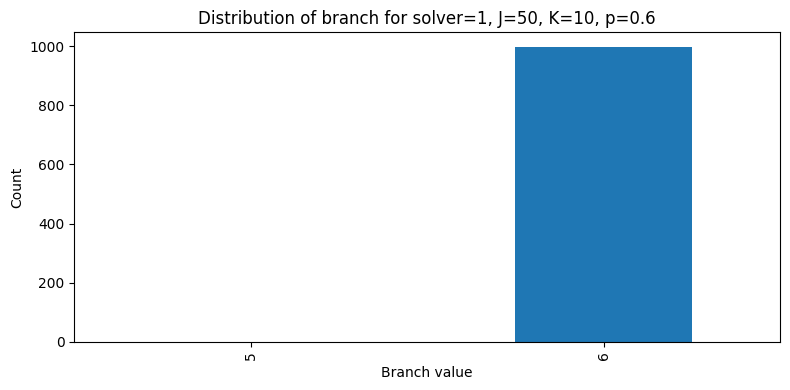


Summary Statistics:
                    Metric     Value
Average runtime (all sims)  9.599693
           avg_runtime_SAT  9.677234
       avg_runtime_branch5  4.817118
       avg_runtime_branch6 10.024385
   Proportion identifiable  0.924925


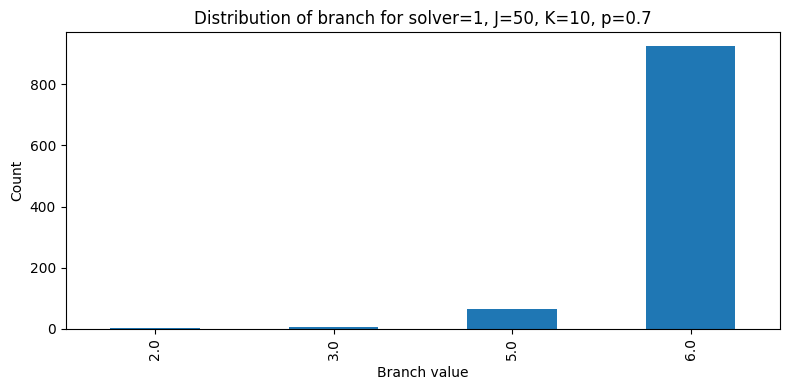


Summary Statistics:
                    Metric     Value
Average runtime (all sims)  4.440357
           avg_runtime_SAT  7.797414
       avg_runtime_branch5  2.447645
       avg_runtime_branch6 80.225060
   Proportion identifiable  0.039157


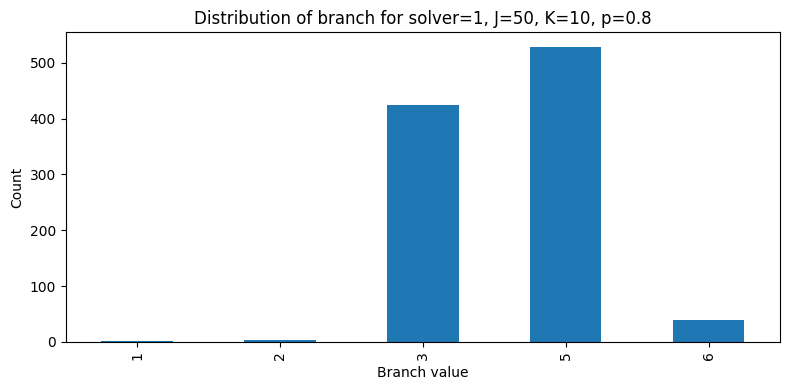


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.001897
           avg_runtime_SAT      NaN
       avg_runtime_branch5      NaN
       avg_runtime_branch6      NaN
   Proportion identifiable 0.000000


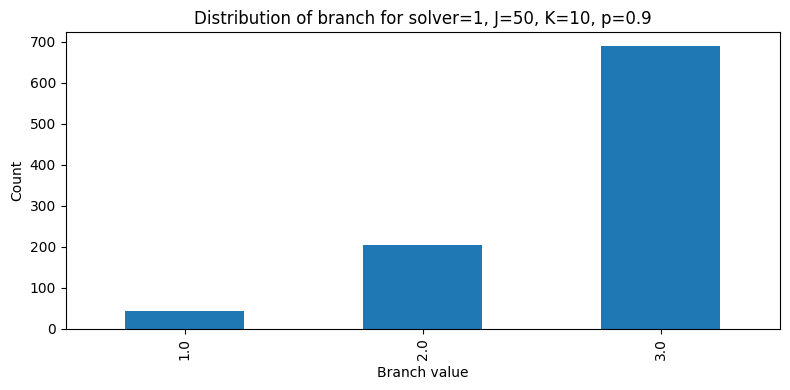

Plots saved: identifiability_with_p.pdf, runtime_vs_p.pdf, sat_runtime_by_outcome_vs_p.pdf


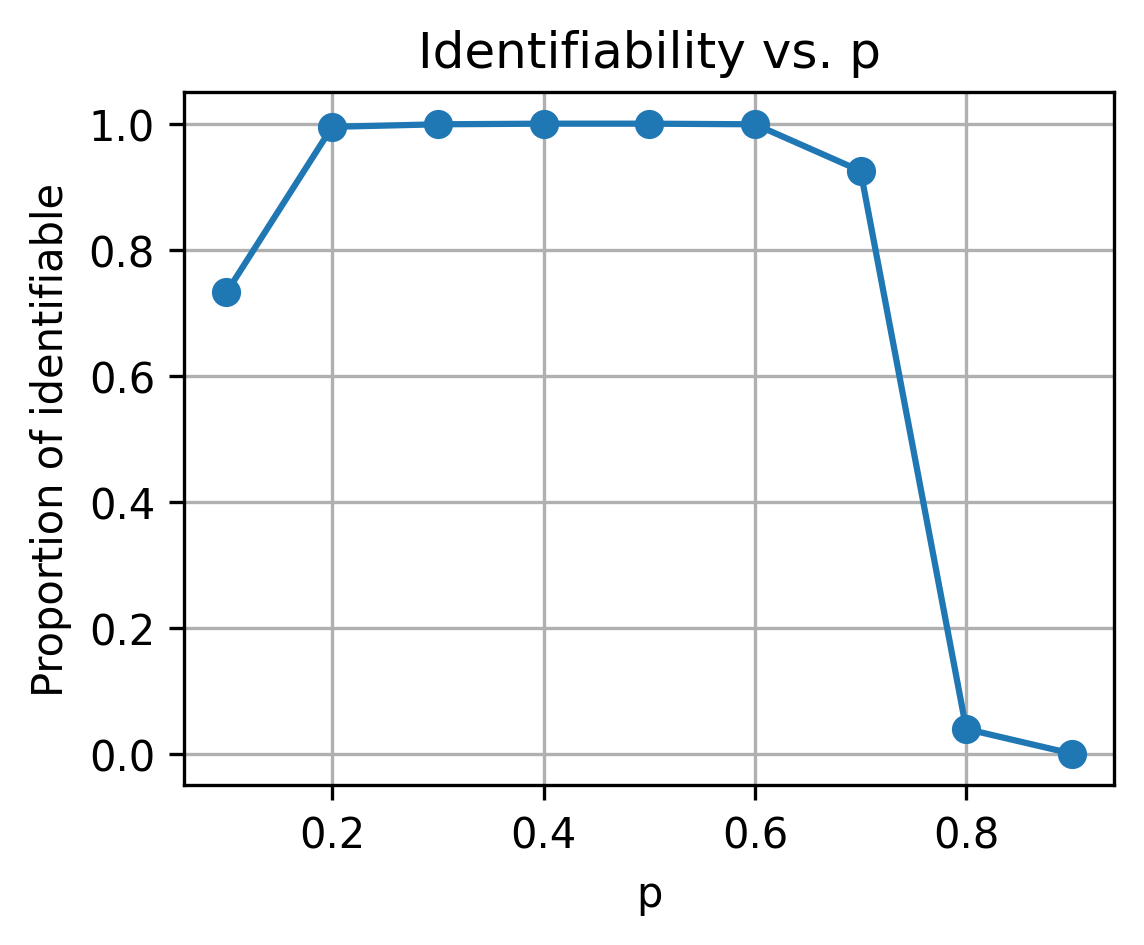

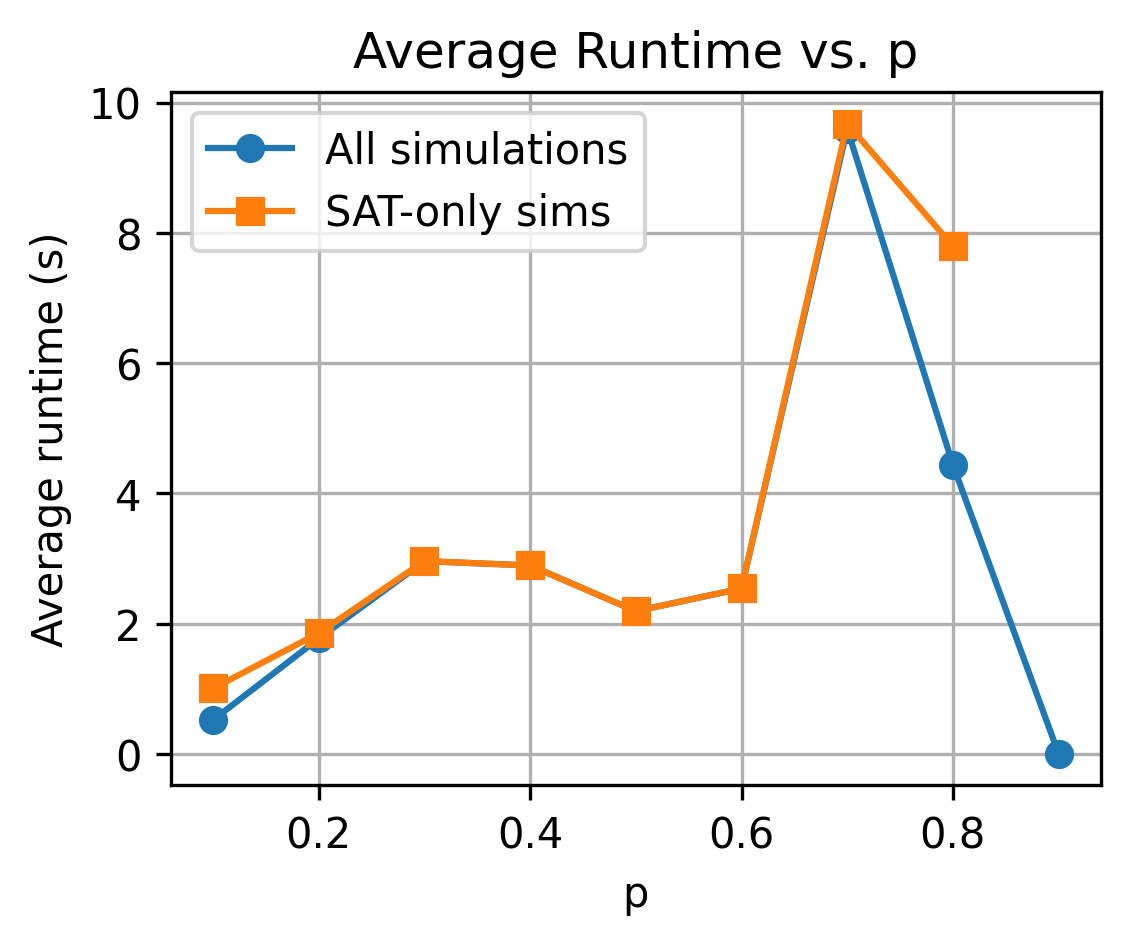

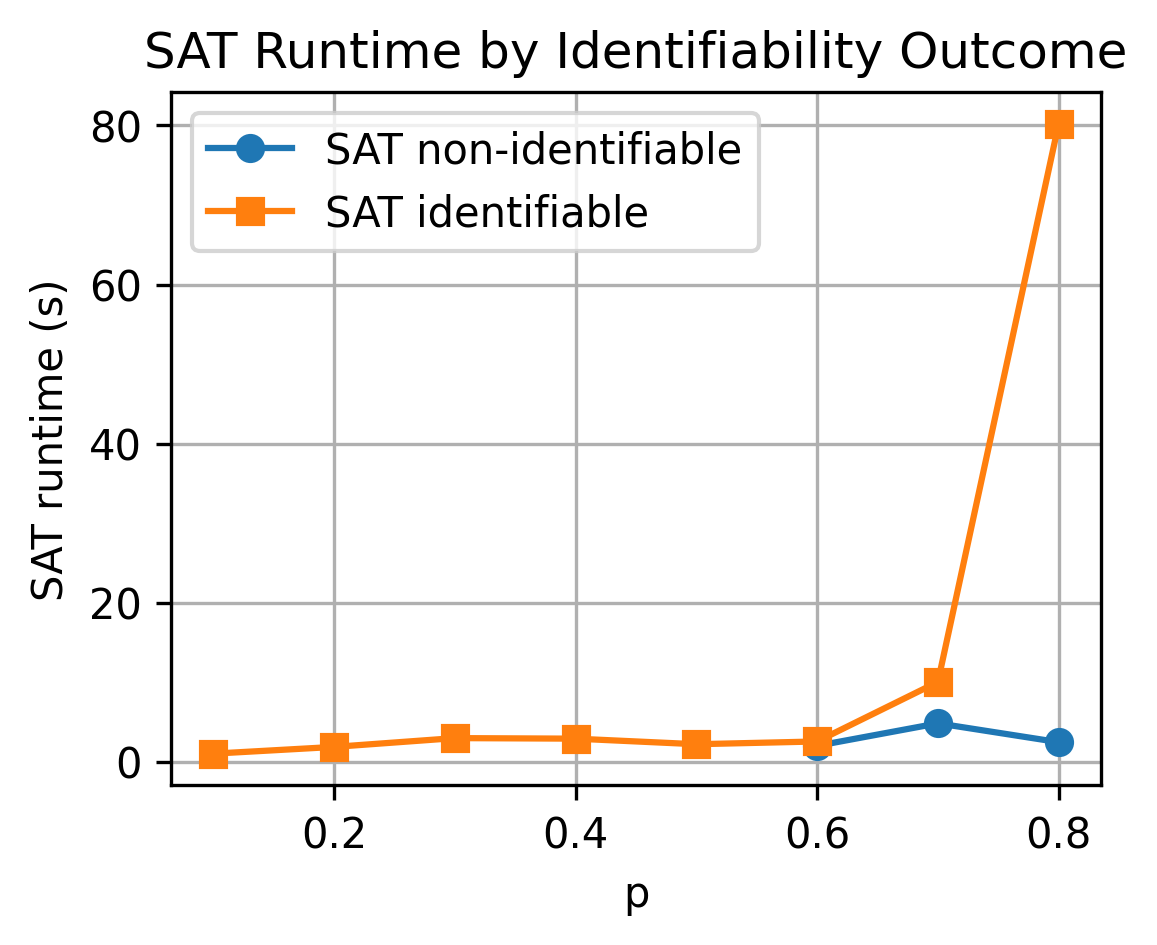

In [72]:
solver = 1
J, K = 50, 10
p_list = [round(0.1 * i, 1) for i in range(1, 10)]
plot_simulation_results(solver, J, K, p_list)

# K = 15


Summary Statistics:
                    Metric      Value
Average runtime (all sims)  65.620867
Average runtime (branch=6) 118.967525
   Proportion identifiable   0.551346


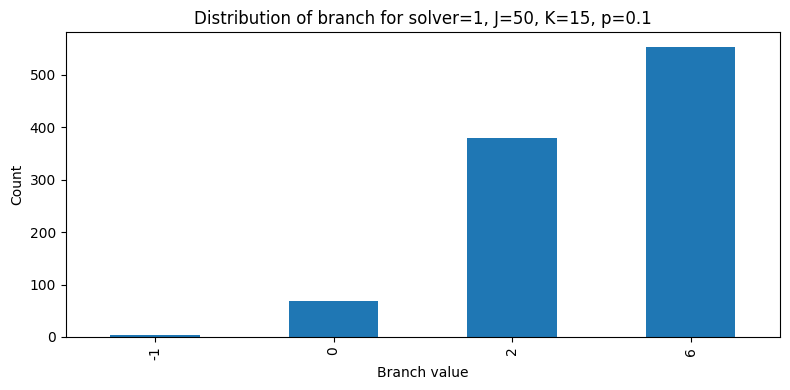

(65.6208674999147, 118.96752529146944, 0.551345962113659)

In [23]:
analyze_results(solver = 1, J = 50, K = 15, p = 0.1)


Summary Statistics:
                    Metric      Value
Average runtime (all sims) 312.065011
Average runtime (branch=6) 317.788204
   Proportion identifiable   0.981982


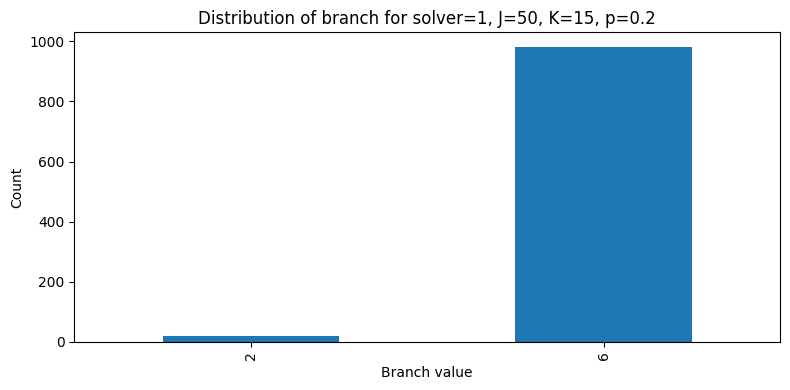

(312.0650109164984, 317.78820424342126, 0.9819819819819819)

In [24]:
analyze_results(solver = 1, J = 50, K = 15, p = 0.2)


Summary Statistics:
                    Metric      Value
Average runtime (all sims) 305.524579
Average runtime (branch=6) 305.524579
   Proportion identifiable   1.000000


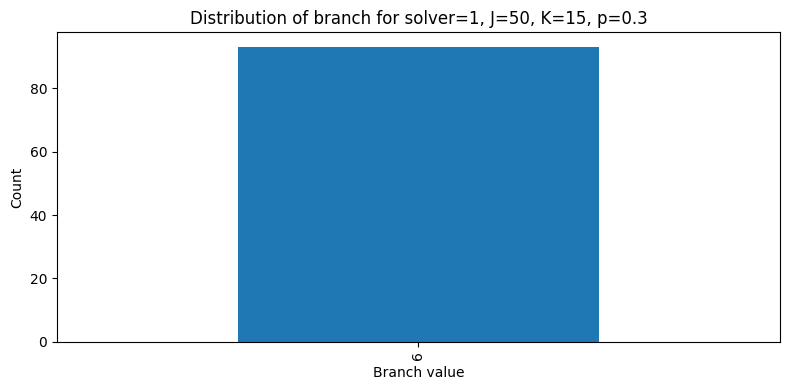

(305.5245790874926, 305.5245790874926, 1.0)

In [25]:
analyze_results(solver = 1, J = 50, K = 15, p = 0.3)


Summary Statistics:
                    Metric      Value
Average runtime (all sims) 901.141618
Average runtime (branch=6) 901.141618
   Proportion identifiable   1.000000


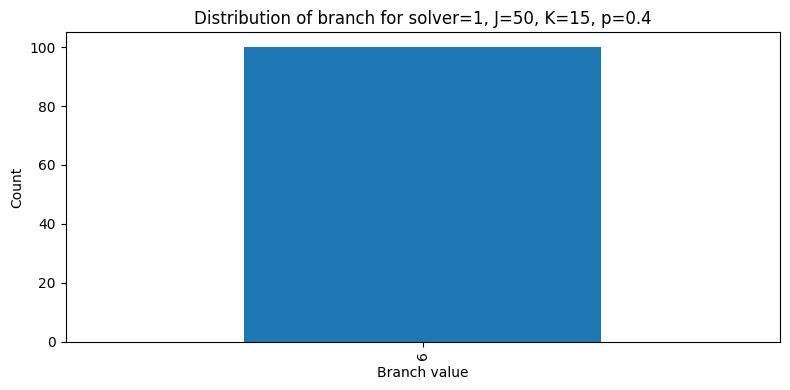

(901.1416180306644, 901.1416180306644, 1.0)

In [24]:
analyze_results(solver = 1, J = 50, K = 15, p = 0.4)


Summary Statistics:
                    Metric       Value
Average runtime (all sims) 6662.727291
Average runtime (branch=6) 6662.727291
   Proportion identifiable    1.000000


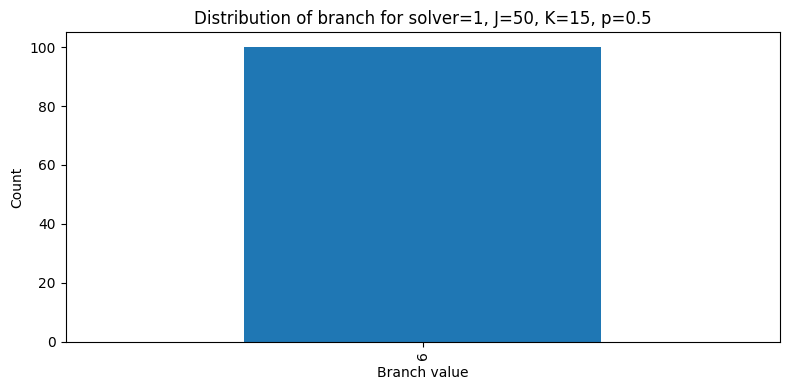

(6662.727291445997, 6662.727291445997, 1.0)

In [25]:
analyze_results(solver = 1, J = 50, K = 15, p = 0.5)

# 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_aggregate(df):
    # Figure 1: Identifiability with p
    plt.figure(figsize=(4, 3), dpi=300)
    plt.plot(df['p'], df['prop_identifiable'], marker='o')
    plt.xlabel('p')
    plt.ylabel('Proportion of identifiable')
    plt.title('Identifiability vs. p')
    plt.grid(True)
    plt.savefig('identifiability_with_p.pdf', bbox_inches='tight')

    # Figure 2: Average Runtime vs p
    plt.figure(figsize=(4, 3), dpi=300)
    plt.plot(df['p'], df['avg_runtime_all'], marker='o', label='All simulations')
    plt.plot(df['p'], df['avg_runtime_SAT'], marker='s', label='SAT-only sims')
    plt.xlabel('p')
    plt.ylabel('Average runtime (s)')
    plt.title('Average Runtime vs. p')
    plt.legend()
    plt.grid(True)
    plt.savefig('runtime_vs_p.pdf', bbox_inches='tight')

    # Figure 3: SAT Runtime by Identifiability Outcome
    plt.figure(figsize=(4, 3), dpi=300)
    plt.plot(df['p'], df['avg_runtime_branch5'], marker='o', label='SAT non-identifiable')
    plt.plot(df['p'], df['avg_runtime_branch6'], marker='s', label='SAT identifiable')
    plt.xlabel('p')
    plt.ylabel('SAT runtime (s)')
    plt.title('SAT Runtime by Identifiability Outcome')
    plt.legend()
    plt.grid(True)
    plt.savefig('sat_runtime_vs_p.pdf', bbox_inches='tight')

    print("Plots saved: identifiability_with_p.pdf, runtime_vs_p.pdf, sat_runtime_by_outcome_vs_p.pdf")




In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_simulation_results_hist(solver, J, K, p_list):
    # Gather results
    results = {
        'p': [],
        'avg_runtime_all': [],
        'prop_identifiable': []
    }
    
    for p in p_list:
        avg_all, _, _, _, prop_id = analyze_results(solver, J, K, p)
        results['p'].append(p)
        results['avg_runtime_all'].append(avg_all)
        results['prop_identifiable'].append(prop_id)
    
    df = pd.DataFrame(results)

    # Figure 1: Proportion identifiable as a bar chart
    plt.figure(figsize=(4, 3), dpi=300)
    bar_width = 0.1
    plt.bar(df['p'], df['prop_identifiable'], width=bar_width, align='center')
    plt.xticks(p_list)                    # show only 0.3, 0.5, 0.7
    plt.xlabel('p')
    plt.ylabel('Proportion identifiable')
    plt.title('Identifiability vs. p')
    # dynamic upper bound: max + 5%
    y_max = df['prop_identifiable'].max() * 1.05
    plt.ylim(0, y_max)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.savefig(f'identifiability_with_p_J{J}_K{K}.pdf', bbox_inches='tight')
    plt.close()

    # Figure 2: Average runtime as a bar chart
    plt.figure(figsize=(4, 3), dpi=300)
    plt.bar(df['p'], df['avg_runtime_all'], width=bar_width, align='center', color='C1')
    plt.xticks(p_list)
    plt.xlabel('p')
    plt.ylabel('Average runtime (s)')
    plt.title('Average Runtime vs. p')
    rt_max = df['avg_runtime_all'].max() * 1.05
    plt.ylim(0, rt_max)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.savefig(f'runtime_vs_p_J{J}_K{K}.pdf', bbox_inches='tight')
    plt.close()

    print("Plots saved: identifiability_with_p.pdf, runtime_vs_p.pdf")



Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.000879
           avg_runtime_SAT 0.004216
       avg_runtime_branch5      NaN
       avg_runtime_branch6 0.004216
   Proportion identifiable 1.000000


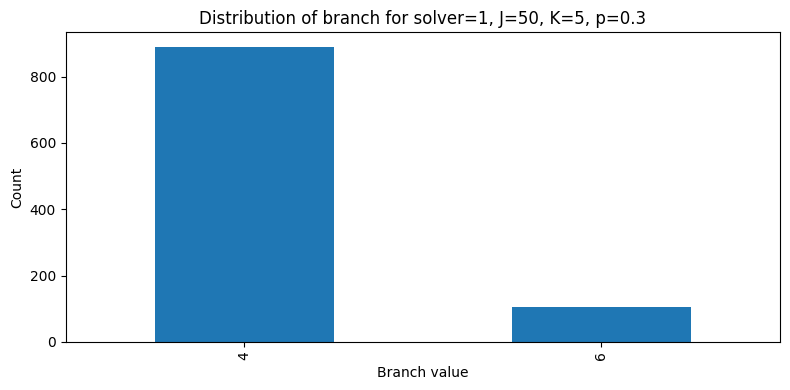


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.003097
           avg_runtime_SAT 0.004197
       avg_runtime_branch5      NaN
       avg_runtime_branch6 0.004197
   Proportion identifiable 1.000000


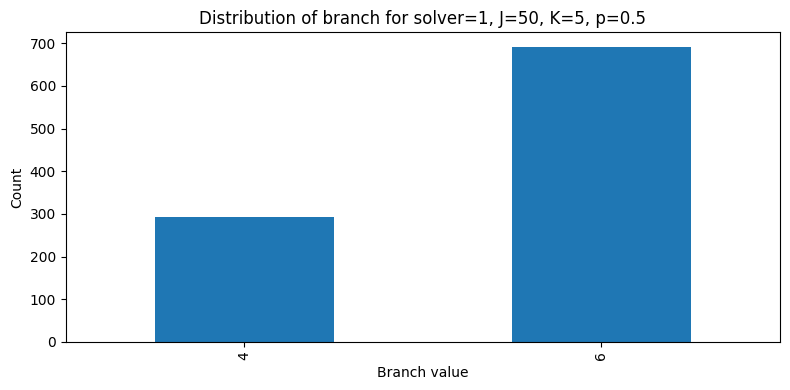


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.004313
           avg_runtime_SAT 0.004313
       avg_runtime_branch5 0.003948
       avg_runtime_branch6 0.004314
   Proportion identifiable 0.997957


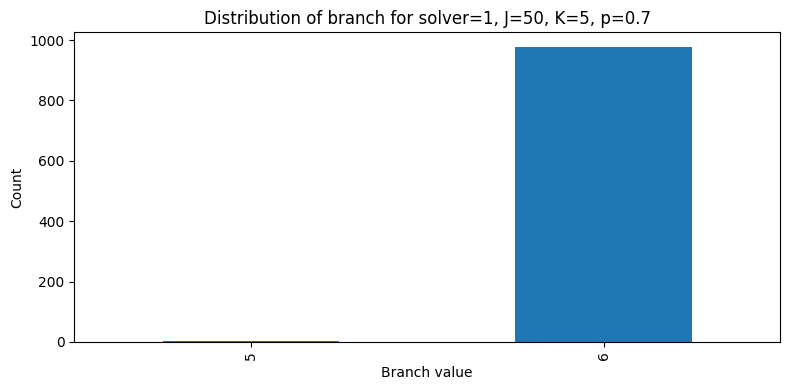

Plots saved: identifiability_with_p.pdf, runtime_vs_p.pdf


In [16]:
solver = 1
J, K = 50, 5
p_list = [0.3, 0.5, 0.7]
plot_simulation_results_hist(solver, J, K, p_list)


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.384422
           avg_runtime_SAT 0.384808
       avg_runtime_branch5      NaN
       avg_runtime_branch6 0.384808
   Proportion identifiable 0.998985


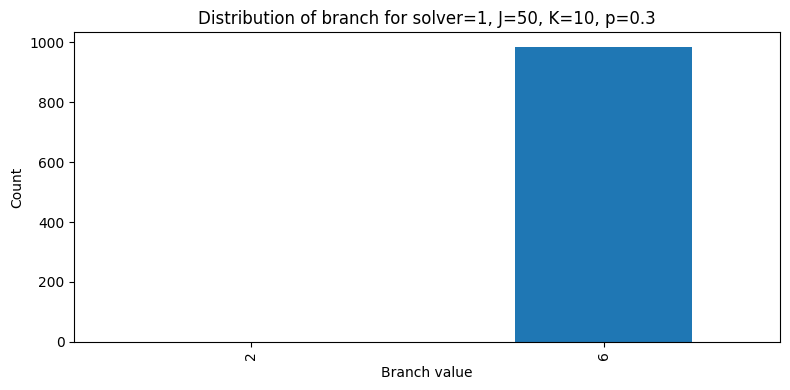


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.319443
           avg_runtime_SAT 0.319443
       avg_runtime_branch5      NaN
       avg_runtime_branch6 0.319443
   Proportion identifiable 1.000000


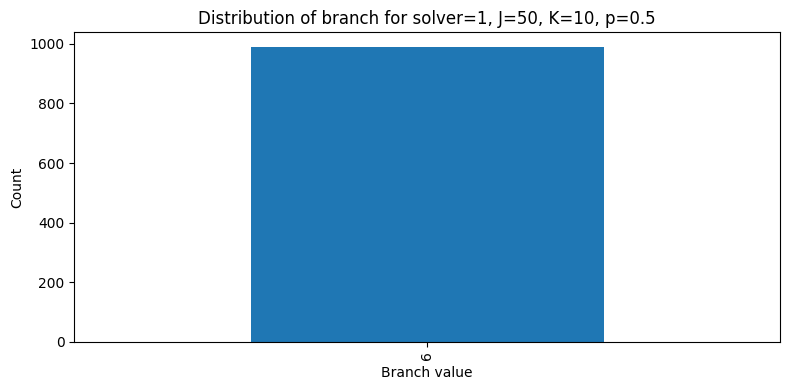


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 3.420471
           avg_runtime_SAT 3.448132
       avg_runtime_branch5 1.711162
       avg_runtime_branch6 3.572471
   Proportion identifiable 0.925703


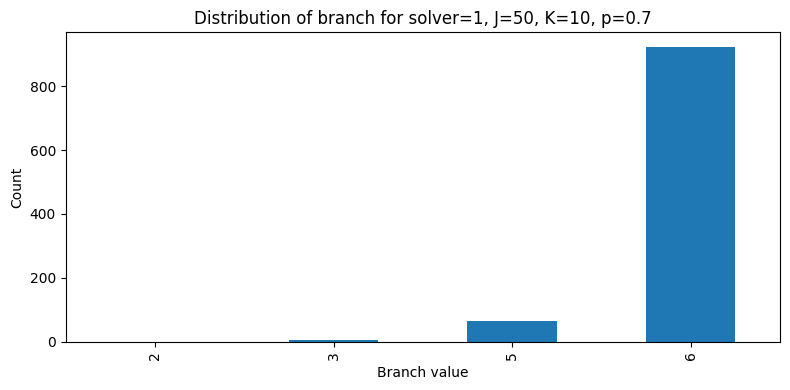

Plots saved: identifiability_with_p.pdf, runtime_vs_p.pdf


In [17]:
solver = 1
J, K = 50, 10
p_list = [0.3, 0.5, 0.7]
plot_simulation_results_hist(solver, J, K, p_list)


Summary Statistics:
                    Metric     Value
Average runtime (all sims) 13.329163
           avg_runtime_SAT 13.342374
       avg_runtime_branch5       NaN
       avg_runtime_branch6 13.342374
   Proportion identifiable  0.999000


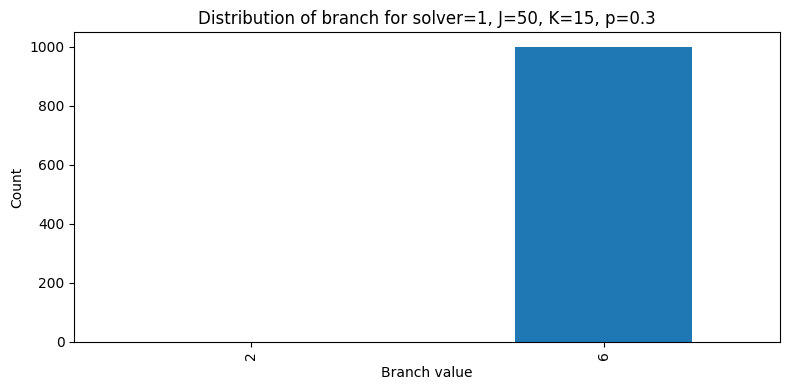


Summary Statistics:
                    Metric      Value
Average runtime (all sims) 397.561176
           avg_runtime_SAT 397.561176
       avg_runtime_branch5        NaN
       avg_runtime_branch6 397.561176
   Proportion identifiable   1.000000


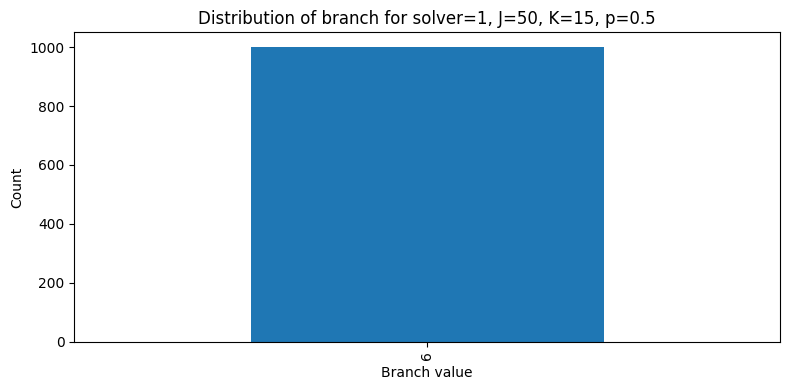


Summary Statistics:
                    Metric        Value
Average runtime (all sims) 11952.461122
           avg_runtime_SAT 12206.768525
       avg_runtime_branch5  5039.060370
       avg_runtime_branch6 89259.631184
   Proportion identifiable     0.083333


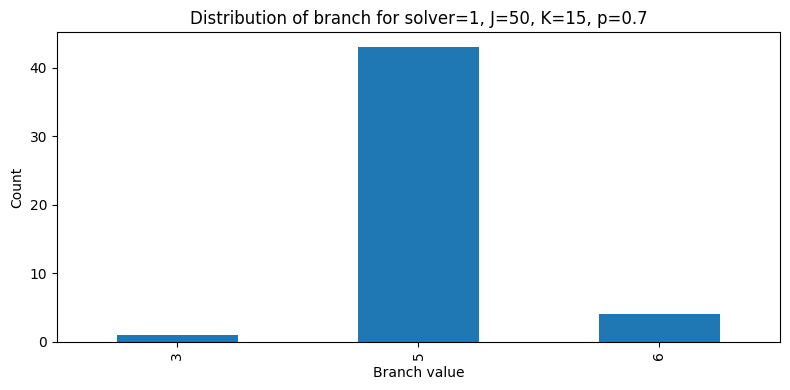

Plots saved: identifiability_with_p.pdf, runtime_vs_p.pdf


In [18]:
solver = 1
J, K = 50, 15
p_list = [0.3, 0.5, 0.7]
plot_simulation_results_hist(solver, J, K, p_list)